In [1]:
%matplotlib inline

##Question 6:


*   Build a CNN and optimize the accuracy for CIFAR-10. Try different number of layers and different architectures (depth and convolutional filter hyperparameters).
*   Is momentum and learning rate having a significant effect? Track the train and test loss across training epochs and plot them for different learning rates and momentum values.
*   Is the depth of the CNN having a significant effect on performance? Describe the hyperparameters of the best model you could train.

### Loading CIFAR-10 Dataset

In [2]:
# Loading Dataset libraries
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
# Computional and Graphical libraries
from matplotlib import pyplot
import numpy as np
import torch
# Debugger Library
from IPython.core.debugger import set_trace

# The CIFAR-10 Dataset loading steps are just from our Q.1
dataset = fetch_openml('CIFAR_10_small')

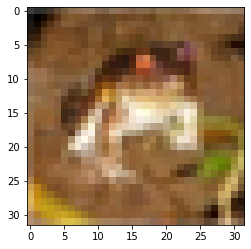

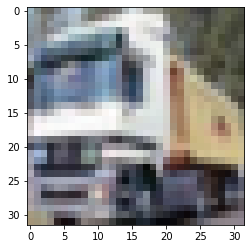

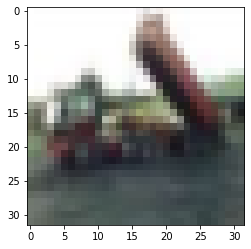

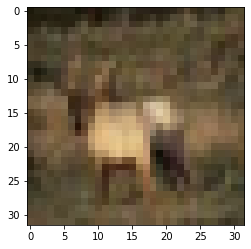

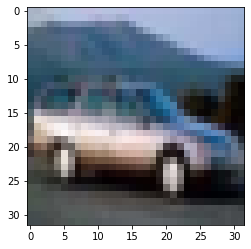

In [3]:
# Some images to make sure we loaded correctly
for i in range(5):
    pyplot.figure(i)
    
    img_raw = dataset['data'][i]
    r = img_raw[0:1024].reshape(32, 32)/255.0
    g = img_raw[1024:2048].reshape(32, 32)/255.0
    b = img_raw[2048:].reshape(32, 32)/255.0

    img = np.dstack((r, g, b))

    pyplot.imshow(img)

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(dataset['data'], dataset['target'], test_size=0.25)
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)
x_train = x_train/255.0
x_valid = x_valid/255.0
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

### Is GPU availble?


In [5]:
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

True


### Classes and Functions

In [6]:
# Training and Validation Datasets/DataLoaders Libraries
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Optim and NN libraries
from torch import optim
from torch import nn
import torch.nn.functional as F

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

loss_func = F.cross_entropy

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)    #valid_loss / len(valid_dl)

        val_acc = val_acc.cpu().detach().numpy() 
        print(epoch, val_loss, val_acc / len(valid_dl))

# Accuracy check from Validation Test.
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x, y):
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

### Initial Variables

In [7]:
bs = 64  # batch size
lr = 0.1  # learning rate
epochs = 2  # how many epochs to train for
a = np.zeros((20, 10), dtype=(float,5))

### Training and Validation Datasets/DataLoaders 


In [8]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

### Original Model, Optim (Use to do Foward Step), and Training

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
model = model.double()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 2.109213362124643 0.2107421875
1 2.0545586561993057 0.2380859375


### Training of Model. Outputs Validation Loss.


In [10]:
# 5 Conv Layers with just more fully connected layers 
model1 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model1.to(dev)
model1 = model1.double()
opt1 = optim.SGD(model1.parameters(), lr=lr, momentum=0.9)
fit(epochs, model1, loss_func, opt1, train_dl, valid_dl)

# Results show this is worse than with only one fully connected layer.

0 2.3025850929940455 0.1103515625
1 2.3025850929940455 0.1103515625


In [11]:
# 5 Conv Layers with pooling in between
model2 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(8),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model2.to(dev)
model2 = model2.double()
opt2 = optim.SGD(model2.parameters(), lr=lr, momentum=0.9)
fit(epochs, model2, loss_func, opt2, train_dl, valid_dl)

# Results same as pooling on last layer only. That is weird.

0 2.3025850929940455 0.1103515625
1 2.3025850929940455 0.1103515625


In [12]:
# 5 Conv Layers with pooling in between
model3 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 13, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(13, 13, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(13, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model3.to(dev)
model3 = model3.double()
opt3 = optim.SGD(model3.parameters(), lr=lr, momentum=0.9)
fit(epochs, model3, loss_func, opt3, train_dl, valid_dl)

0 2.3025850929940455 0.1103515625
1 2.3025850929940455 0.1103515625


In [13]:
model4 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=4, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model4.to(dev)
model4 = model4.double()
opt4 = optim.SGD(model4.parameters(), lr=lr, momentum=0.9)
fit(epochs, model4, loss_func, opt4, train_dl, valid_dl)

# Changing Kernel_size to be larger seems to have worse results.

0 2.302584732159884 0.1107421875
1 2.302556248813278 0.103515625


In [14]:
model5 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=5, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model5.to(dev)
model5 = model5.double()
opt5 = optim.SGD(model5.parameters(), lr=lr, momentum=0.9)
fit(epochs, model5, loss_func, opt5, train_dl, valid_dl)

0 2.3025512627227736 0.1169921875
1 2.302378666186078 0.1130859375


In [15]:
model6 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=2, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=2, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=2, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model6.to(dev)
model6 = model6.double()
opt6 = optim.SGD(model6.parameters(), lr=lr, momentum=0.9)
fit(epochs, model6, loss_func, opt6, train_dl, valid_dl)

0 2.243114498017494 0.1849609375
1 2.0964484900731475 0.2154296875


### Testing different learning rate and momentum values.


In [16]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, mat, lr, momentum):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)    #valid_loss / len(valid_dl)
        val_acc = val_acc.cpu().detach().numpy()  / len(valid_dl)
        mat_data = (epoch, lr, momentum, val_loss, val_acc)
        mat[int(((lr*20)-2)+epoch)][int(momentum*10)] = mat_data
        print(epoch, val_loss, val_acc)
    return mat
################################################################################
model7 = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)
model7.to(dev)
model7 = model7.double()
for x in range(10):           # Varying for LR from 0.1 to 1.0  
  lr = (x+1)/10
  for y in range(10):         # Varying for Momentum 0.0 to 0.9
    momentum = y/10
    opt7 = optim.SGD(model7.parameters(), lr=lr, momentum=momentum)
    print(lr, momentum)
    a = fit(epochs, model7, loss_func, opt7, train_dl, valid_dl, a, lr, momentum)


0.1 0.0
0 2.28720088555686 0.1498046875
1 2.285584655364973 0.1533203125
0.1 0.1
0 2.286292898719735 0.151171875
1 2.249462868456282 0.171875
0.1 0.2
0 2.121332032971835 0.2103515625
1 2.0975444850309555 0.255859375
0.1 0.3
0 2.0604419508548695 0.2689453125
1 1.9982703734114629 0.2880859375
0.1 0.4
0 1.9737876159231718 0.308203125
1 1.9432801668428197 0.328125
0.1 0.5
0 1.9398057983550272 0.302734375
1 1.8868234068432033 0.3125
0.1 0.6
0 1.7716240237317864 0.3640625
1 1.7499525268071554 0.3708984375
0.1 0.7
0 1.7039730151178722 0.4005859375
1 1.73939459486864 0.3734375
0.1 0.8
0 1.6526357994236591 0.3908203125
1 1.6495322156049 0.398828125
0.1 0.9
0 1.626560652886935 0.4185546875
1 1.5860305003204371 0.4201171875
0.2 0.0
0 1.5390252734280874 0.4369140625
1 1.6015119675439928 0.405078125
0.2 0.1
0 1.576604671296549 0.4162109375
1 1.5524823023864927 0.43046875
0.2 0.2
0 1.495589268229011 0.456640625
1 1.551299569743376 0.4416015625
0.2 0.3
0 1.5360280605341687 0.437890625
1 1.52827967345

### Graphical Illustration of Accuracy for Varying Values of Learning Rate and Momentum

In [17]:
def Largest_Moment(mat, index):
  best_Momentum_index = 0;
  for x in range(10):
    if(mat[index][x][4] > mat[index][best_Momentum_index][4]):
      best_Momentum_index = x
  return best_Momentum_index

mat_lr = np.zeros(20)
mat_moment = np.zeros(20)
mat_acc = np.zeros(20)

for i in range(20):
  mat_lr[i] = a[i][0][1]
  # Momentum index with greatest Accuracy of a given LR.
  large = Largest_Moment(a, i)
  mat_moment[i] = a[i][large][2]
  mat_acc[i] = a[i][large][4]

The arrays of LR, Momentum, and Accuracy should be counted in groups of 2. First Value is epoch 1, second value is epoch 2. Then LR/Momentum will increment. For example, below we see that the 8th value in accuracy array is the largest. This corresponds to a learning rate of 0.5 and momentum 0.4 and epoch 1. Loss of valiation sets are also shown as 0.9500714. 

In [23]:
print(mat_acc)
print(mat_moment[5])
print(a[5][2])

[0.41855469 0.42011719 0.45664063 0.45429687 0.46816406 0.47695312
 0.45253906 0.4640625  0.43730469 0.44335938 0.43710938 0.4328125
 0.43085937 0.43613281 0.41855469 0.42695312 0.38652344 0.40214844
 0.38125    0.37304688]
0.2
[1.         0.3        0.2        1.46697405 0.47695312]


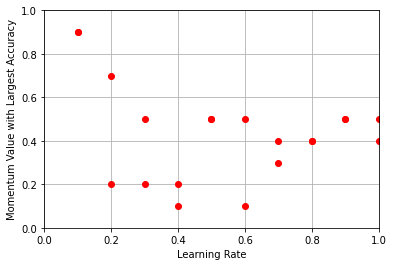

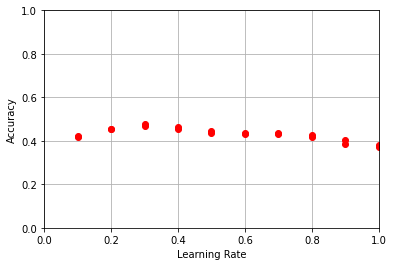

In [19]:
fig, ax = pyplot.subplots()
ax.plot(mat_lr, mat_moment, 'ro')
ax.axis([0, 1, 0, 1])
ax.set(xlabel='Learning Rate', ylabel='Momentum Value with Largest Accuracy')
ax.grid()
pyplot.show()

fig, ax = pyplot.subplots()
ax.plot(mat_lr, mat_acc, 'ro')
ax.axis([0, 1, 0, 1])
ax.set(xlabel='Learning Rate', ylabel='Accuracy')
ax.grid()
pyplot.show()

Overall Kernel_sizing seemed to be fine where it was at, at Kernel_size = 3. Adding extra Conv2D and ReLu() fully connected layers seems to have caused greater loss and a lower accuracy score than when only using 3 conv layers.

From the plot above. We got our best accuracy, 0.47695312, with a learning rate of 0.3 and a momentum of 0.2. In the graphs above, every LR has two dots since there is 2 epochs. Compared to adjusting Kernel_size and convolution layers, adjusting LR and Momentum seems to have the most significant effects.